In [1]:
import pickle
import torch

path0= 'checkpoints/lamackl/test_v1'  # input checkpoint dir

with open(f'{path0}/history.pkl', 'rb') as f:
    history = pickle.load(f)
batch=len(history['phi_loss'][0])

In [ ]:
### observing Loss in moving average
from matplotlib import pyplot as plt

a = []
title0= 'phi_loss'  # corresponds to   L_{solve}  in the Algorithm 1.

for i in history[title0]:  
    if len(i)==batch:
        a.extend(i)
his_tensor = torch.stack(a).reshape(-1,len(i)).transpose(0,1)
his_mean = his_tensor.mean(dim=0)
stride=30
his_momen =[]
for i in range(len(his_mean)-stride):
    his_momen.append(his_mean[i:i+stride].mean())
plt.plot(list(range(len(his_momen))), his_momen)

plt.title(title0)

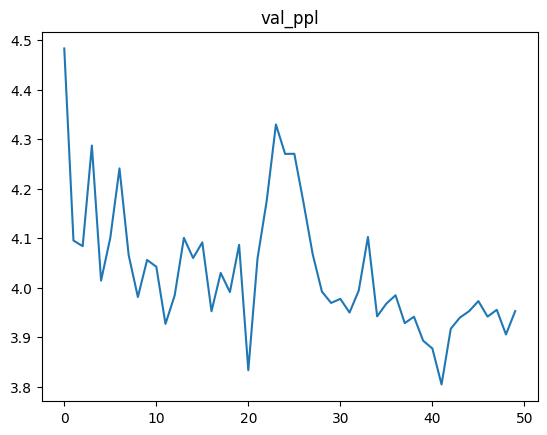

In [12]:
#### observing validation metric (score or ppl) 
a = []
#========= control ========
title0= 'val_score'
# title0= 'val_ppl'
#==========================

for i in history[title0]:  
    a.append(i)
plt.title(title0)
plt.plot(list(range(len(a))), a)

In [ ]:
######################### Observing Weight ###################
### Observe the heat map of the token weights, predicted upon the validation data.

from transformers import AutoTokenizer
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont

model_name = "meta-llama/Llama-2-7b-hf"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token   

##### control ##############
num0 = -1  #  last valiation
id0 = 14  # 14th validation data
##############################

weight_mu = history['val_weight_mu'][num0][id0]
tokens = history['val_Data'][num0][id0]
weight_mu = weight_mu / torch.mean(weight_mu)
decoded_words=[]
for token0 in tokens[1:]:

    word = tokenizer.decode([token0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    decoded_words.append(word)
decoded_words = ['\s' if x == '' else x for x in decoded_words]

colors = []
for w, p in zip(decoded_words, weight_mu):
        colors.append([w, (int(255*p),150,100)])

words = decoded_words#[num]
block_width = 50
block_height = 20
max_blocks_per_row = 20  # Adjust as needed to fit your desired layout

# Calculate the image size
img_width = block_width * min(len(words), max_blocks_per_row)
img_height = block_height * ((len(words) - 1) // max_blocks_per_row + 1)
image = Image.new('RGB', (img_width, img_height), (255, 255, 255))
draw = ImageDraw.Draw(image)

# Set up the font
try:
    font = ImageFont.truetype("arial.ttf", 16)  # Adjust font size as needed
except IOError:
    font = ImageFont.load_default()

# Draw the color blocks and the words on them
for i, (word, color) in enumerate(colors):
    row = i // max_blocks_per_row
    col = i % max_blocks_per_row
    x_position = col * block_width
    y_position = row * block_height
    
    # color = word_to_color(word)
    draw.rectangle([x_position, y_position, x_position + block_width, y_position + block_height], fill=color)
    
    # Adjust text position if necessary
    text_x = x_position + 5  # Small padding from the left
    text_y = y_position + (block_height - 8) / 2  # Vertically center text
    draw.text((text_x, text_y), word, fill="black", font=font)

# Display or save the image
image.show()  